# Inference
> Performing inference without using fastai

We want to perform inference on the trained model,

- Load the trained model with fastai using pure Pytorch
- Convert the model to Half precision
- Postprocess the raw model output to get a segmentation mask

In [1]:
from functools import partial
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

torch.cuda.set_device(1)
torch.cuda.get_device_name(1)

'Quadro RTX 8000'

In [2]:
PATH = Path.cwd().parent/'WSISEG-Database'

size = 256
image_paths = PATH/f'images{size}'

let's get all images

In [3]:
files = list(image_paths.iterdir())

In [4]:
def label_func(fn): 
    folder = fn.parent.name.replace('images', 'masks')
    return (fn.parent.parent/folder)/fn.name

and grab one:

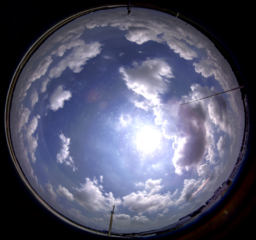

In [5]:
first_image_path = files[0]

img = Image.open(first_image_path)
mask_gt = Image.open(label_func(first_image_path))
img

load the model:

In [6]:
model = torch.jit.load('../model_checkpoints/baseline_unet.jit', map_location='cuda:1')
model.eval();

we can reproduce fastai transforms using torchvision ones:

In [7]:
WSISEG_STATS = [0.3114, 0.3166, 0.3946],[0.2587, 0.2598, 0.2958]

image = Image.open(first_image_path).convert("RGB")
image_tfm = T.Compose(
    [   T.ToTensor(),
        T.Normalize(mean=WSISEG_STATS[0], std=WSISEG_STATS[1]),
    ]
)

we can call the model into the image we just loaded:

In [8]:
x = image_tfm(image).unsqueeze_(0).cuda()
raw_out = model(x)

and check inference speed:

In [9]:
%timeit model(x)

2.57 ms ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
def to_mask(raw_out):
    "get the segmentation mask from the model output"
    if raw_out.device.type == 'cuda':
        raw_out = raw_out.cpu()
    p_torch = raw_out[0].argmax(dim=0).numpy().astype(np.uint8)
    return p_torch

In [11]:
mask = to_mask(raw_out)
mask.shape

(240, 256)

show results

In [15]:
def show_images(imgs, titles=None):
    "show images with optional titles"
    fig, axes = plt.subplots(1,len(imgs), figsize=(5*len(imgs), 5))
    if titles is None:
        titles = [None]*len(imgs)
    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img)
        if title is not None: 
            ax.set_title(title)
        ax.axis('off')

In [13]:
mask = Image.fromarray(to_mask(raw_out)*100)

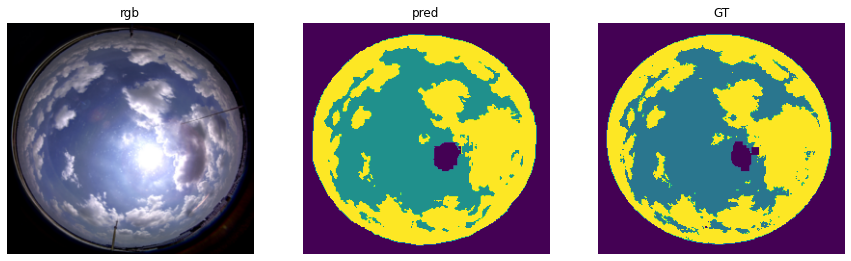

In [14]:
show_images([img, mask, mask_gt], titles=['rgb', 'pred', 'GT'])